In [1]:
batch_size = 64
ncomps = 500
crop_size = 180

In [2]:

import os
import sys
import random
import numpy as np
import pandas as pd
import torch
from monai.data import DataLoader
from monai.transforms import Compose, NormalizeIntensity, ToTensor
import matplotlib.pyplot as plt
# import config_file as cfg
# from utils import get_model
# from torchsummary import summary

import torchvision.transforms.functional as F

/home/volatope/Software/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
2024-05-29 11:17:33.948572: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-29 11:17:33.949684: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-29 11:17:33.974705: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow w

In [3]:
from pathlib import Path

macaw_path = Path(os.getcwd())
sys.path.append(str(macaw_path) +'/')
exp_name = 'far_bias'

train_csv_path = macaw_path/'splits'/'train.csv'
train_img_path = macaw_path/exp_name/'train'

test_csv_path = macaw_path/'splits'/'test.csv'
test_img_path = macaw_path/exp_name/'test'
# 
pca_path = macaw_path/exp_name/f'train_hc_pca_{ncomps}.pkl'
# 
train_path = macaw_path/exp_name/f'train_hc_data_PCA_{ncomps}.pkl'
test_path = macaw_path/exp_name/f'test_hc_data_PCA_{ncomps}.pkl'

In [4]:
home_dir = './'
working_dir = home_dir + exp_name + '/'

df_train = pd.read_csv(os.path.join(home_dir, "splits/train.csv"))
# df_val = pd.read_csv(os.path.join(home_dir, "splits/val.csv"))

train_fpaths = [os.path.join(working_dir, "train", filename.replace(".nii.gz", ".tiff")) for filename in df_train['filename']]
train_class_label = df_train['class_label']

# val_fpaths = [os.path.join(working_dir, "val", filename.replace(".nii.gz", ".tiff")) for filename in df_val['filename']]
# val_class_label = df_val['class_label']

In [5]:
if exp_name=='no_bias': 
    df_train['bias_label'].values[:]=0
    
df_train.bias_label.max()

1

In [6]:
df_train.isna().sum()

Unnamed: 0        0
isv_dst           0
effect_dst        0
isv_bin           0
effect_bin        0
both_bins         0
bias_label        0
class_label       0
strat_col         0
filepath       1005
filename          0
dtype: int64

In [7]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [8]:
seed = 1  # You can use any integer as the seed
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(seed)
np.random.seed(seed)

g = torch.Generator()
g.manual_seed(seed)

In [9]:
from utils.datasets import EmmaDataset
from monai.data import pad_list_data_collate
from torchvision.transforms import CenterCrop
from utils.customTransforms import ToFloatUKBB

# Define transforms
transforms = Compose([ToTensor(),CenterCrop(crop_size),ToFloatUKBB()])
# train_dataset = UKBBT1Dataset(train_csv_path, train_img_path, transforms.Compose([ToFloatUKBB(),ToTensor(), CenterCrop(crop_size)]))

# create a training data loader - include padding
# train_ds = ImageDataset(image_files=train_fpaths, labels=train_class_label, transform=transforms, reader="ITKReader")
train_ds = EmmaDataset(train_csv_path, train_img_path, exp_name=='no_bias',transforms)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0,worker_init_fn=seed_worker, generator=g, pin_memory=torch.cuda.is_available(), collate_fn=pad_list_data_collate)

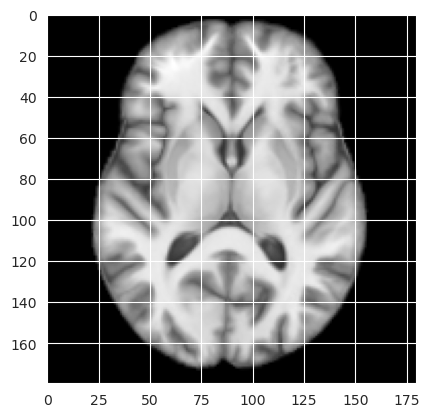

In [10]:
plt.imshow(next(iter(train_loader))[2][1], cmap='gray')

In [11]:
imgs = np.concatenate([d[2].numpy() for d in train_loader],axis=0)
imgs = imgs.reshape(imgs.shape[0],-1)
imgs_dim = imgs.shape[1]

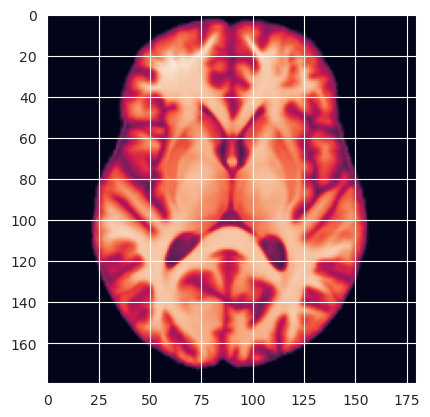

In [12]:
plt.imshow(imgs[0].reshape(crop_size,crop_size))

## Dimensionality reduction

In [13]:
import pickle
from sklearn.decomposition import PCA

# if os.path.exists(pca_path):
#     with open(pca_path, 'rb') as f:
#         pca = pickle.load(f)
# else:
pca = PCA(n_components=ncomps)
pca.fit(imgs)

with open(pca_path, 'wb') as f:
    pickle.dump(pca, f)

In [14]:
disease = np.concatenate([d[0].numpy() for d in train_loader],axis=0)
bias = np.concatenate([d[1].numpy() for d in train_loader],axis=0)

In [15]:
encoded_data = pca.transform(imgs)

In [16]:
with open(train_path, 'wb') as f:
    pickle.dump({'imgs':imgs, 'disease':disease,'bias':bias, 'pca':pca,'encoded_data':encoded_data}, f)

In [17]:
test_ds = EmmaDataset(test_csv_path, test_img_path, exp_name=='no_bias', transforms)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=seed_worker, generator=g, pin_memory=torch.cuda.is_available(), collate_fn=pad_list_data_collate)

In [18]:
test_ds.df['bias_label'].min()

0

In [19]:
test_ds.df.isna().sum()

Unnamed: 0       0
isv_dst          0
effect_dst       0
isv_bin          0
effect_bin       0
both_bins        0
bias_label       0
class_label      0
strat_col        0
filepath       499
filename         0
dtype: int64

In [20]:
test_ds.df.shape

(499, 11)

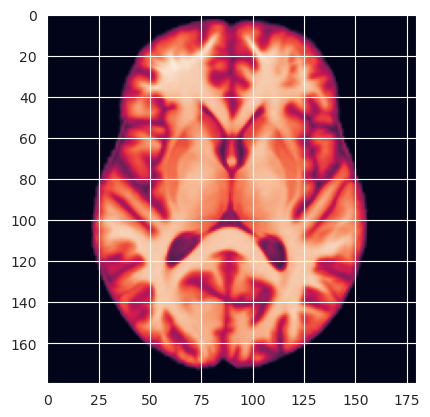

In [21]:
plt.imshow(next(iter(train_loader))[2][1])

In [22]:
test_imgs = np.concatenate([d[2].numpy() for d in test_loader],axis=0)
test_imgs = test_imgs.reshape(test_imgs.shape[0],-1)
test_imgs_dim = test_imgs.shape[1]

In [24]:
test_img_names = np.concatenate([d[3] for d in test_loader],axis=0)
test_img_names

array(['00046_-0.446_S_-0.651_D_2.727_B.tiff',
       '00426_0.288_S_-1.44_D.tiff', '00254_0.356_S_0.536_D.tiff',
       '00177_-1.825_S_0.626_D_2.042_B.tiff',
       '00219_0.551_S_0.574_D_0.775_B.tiff',
       '00022_-0.732_S_-0.119_D_1.865_B.tiff',
       '00202_0.449_S_0.254_D_2.308_B.tiff',
       '00127_-0.597_S_-1.545_D_2.524_B.tiff',
       '00194_0.683_S_0.365_D_3.188_B.tiff',
       '00227_1.142_S_0.561_D_0.369_B.tiff',
       '00213_-0.176_S_-0.224_D_2.775_B.tiff',
       '00235_-0.959_S_1.102_D_2.889_B.tiff', '00425_-0.46_S_-0.1_D.tiff',
       '00401_-0.341_S_-0.762_D.tiff', '00488_-0.23_S_-1.902_D.tiff',
       '00176_0.26_S_-0.941_D_1.539_B.tiff',
       '00383_0.138_S_-1.446_D.tiff',
       '00059_-0.063_S_0.039_D_1.544_B.tiff',
       '00313_-0.67_S_-0.756_D.tiff', '00260_-1.431_S_-1.264_D.tiff',
       '00251_1.257_S_-0.56_D.tiff', '00183_-0.41_S_0.968_D_0.615_B.tiff',
       '00483_-0.145_S_-0.578_D.tiff',
       '00210_1.653_S_2.173_D_0.434_B.tiff',
       '00206_0.

In [25]:
sample_imgs = test_imgs[:5,:]
t = pca.transform(sample_imgs)
X_recon = pca.inverse_transform(t)

Disease: [1 0 0 1 0]
Bias: [0 1 1 0 0]


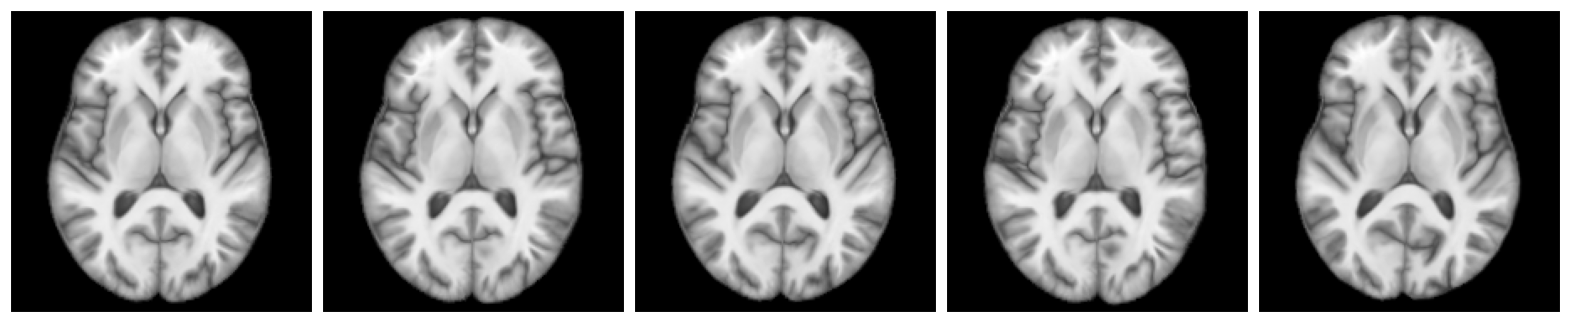

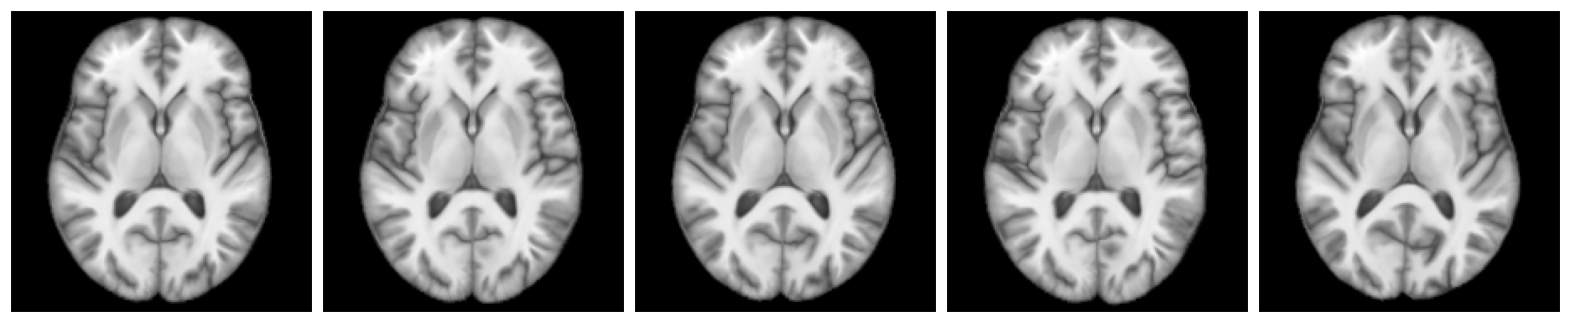

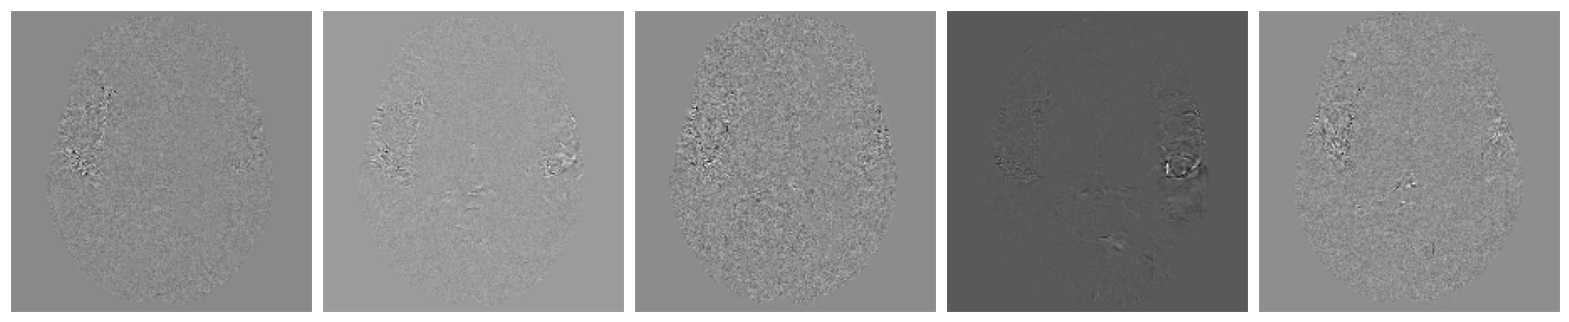

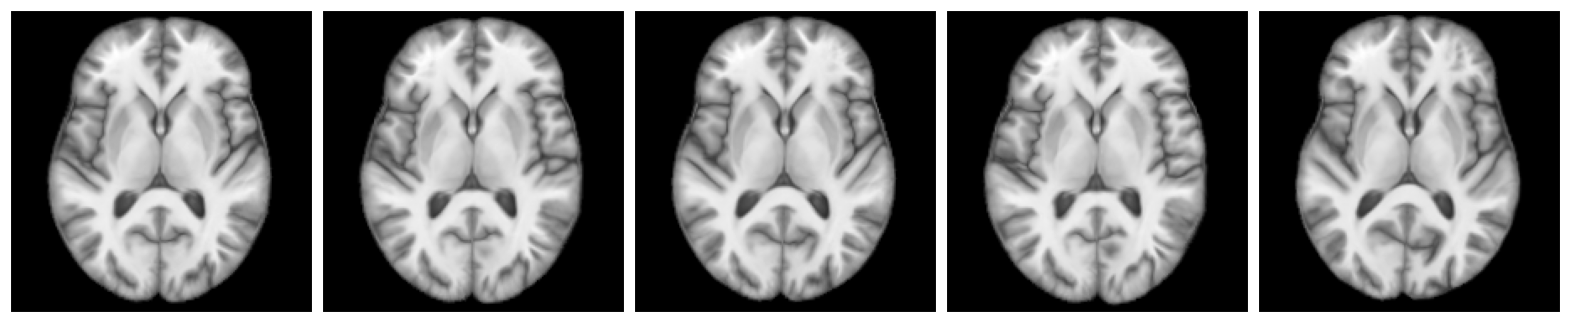

In [26]:
import utils.visualize as vis
print("Disease:", disease[:5])
print("Bias:",bias[:5])

plt.rcParams["figure.figsize"] = 20,5

diff = sample_imgs - X_recon
rr = X_recon + diff
fig = vis.img_grid([d.reshape(crop_size,crop_size) for d in sample_imgs], clim=(0,1), cols=5)
fig = vis.img_grid([d.reshape(crop_size,crop_size) for d in X_recon], clim=(0,1), cols=5)
fig = vis.img_grid([d.reshape(crop_size,crop_size) for d in diff],cols=5, cmap='gray')
fig = vis.img_grid([d.reshape(crop_size,crop_size) for d in rr], clim=(0,1), cols=5)

In [27]:
disease = np.concatenate([d[0].numpy() for d in test_loader],axis=0)
bias = np.concatenate([d[1].numpy() for d in test_loader],axis=0)

In [28]:
np.min(X_recon)

-0.0062745214

In [29]:

encoded_data = pca.transform(test_imgs)

In [30]:
with open(test_path, 'wb') as f:
    pickle.dump({'imgs':test_imgs, 'disease':disease,'bias':bias, 'pca':pca,'encoded_data':encoded_data, 'img_names':test_img_names}, f)

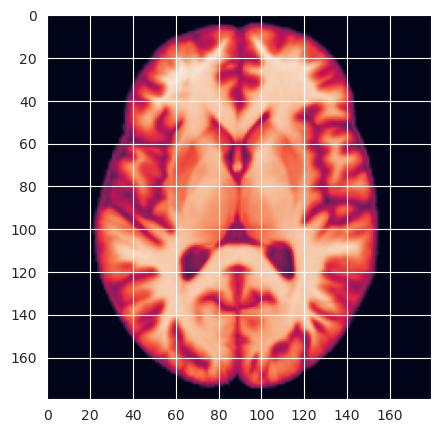

In [31]:
plt.imshow(test_imgs[1].reshape(crop_size,crop_size))